In [128]:
import pandas as pd
import matplotlib as mtl
import seaborn as sns

import matplotlib.pyplot as plt
from scipy import stats

from os import listdir
from os.path import isfile, join

import numpy as np
import math

from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import ttest_ind
from scipy.stats import friedmanchisquare

In [2]:
#subpaths: FR FT SR ST base_pc base_tablet
path_to_data = '*\studiendatengeordnet\\'

In [225]:
def load_df_in_folder(folder_path):
    files = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    frames = []
    for file in files:
        df = pd.read_csv(join(folder_path, file), sep=';')
        df = df.replace({',': '.'}, regex=True)
        df.columns = df.columns.str.replace(' ', '')
        df = df.apply(pd.to_numeric)
        frames.append(df)
    return frames

In [4]:
def load_all_test_types(folder_path):
    test_ids = ['FT', 'FR', 'ST', 'SR']
    combined_test_df = []
    for test_id in test_ids:
        df_frames = load_df_in_folder(join(folder_path, test_id))
        combined_test_df.append(pd.concat(df_frames))
    combined_test_df = pd.concat(combined_test_df)
    return combined_test_df

In [19]:
FT_frames = load_df_in_folder(join(path_to_data, 'FT'))

In [226]:
all_data = load_all_test_types(path_to_data)

all_data['click_time'] = all_data['tsHit'] - all_data['tsSpawn']

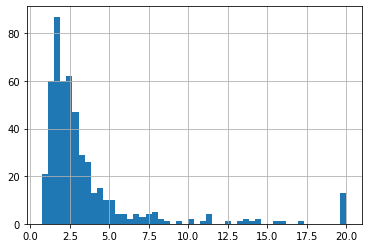

In [6]:
test = all_data.clip(-1, 20)
test['click_time'].hist(bins=50)

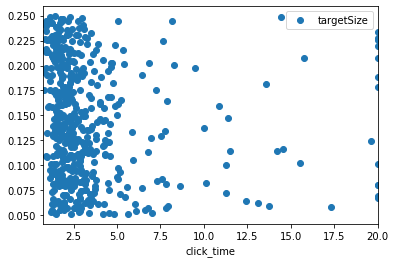

In [58]:
test.plot(x='click_time', y='targetSize', style='o')

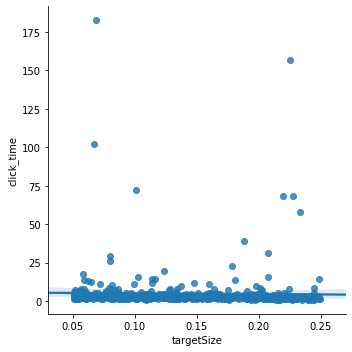

In [59]:
import seaborn as sns
sns.lmplot(y='click_time', x='targetSize', data=all_data, fit_reg=True) 

## T-test ob Ziele außerhalb des FOV tatsächlich langsamer zu erreichen sind

In [6]:
#Test number 3 Does FOV significantly impact the MT?
#ToDo:
#get Vectors from Dataset DONE
#calculate angle vector to target vs viewing vector DONE
#create two sets, one with angles over 43°/2 (outside FOV), one under 43°/2 (inside FOV)
#check normaldistribution, check if variance is similar
#perform t-test

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    radians = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    return math.degrees(radians)

In [7]:
#gazeX	gazeY	gazeZ	targetDirX	targetDirY	targetDirZ
#creating vector columns
all_data['gaze_vector'] = list(zip(all_data.gazeX, all_data.gazeY, all_data.gazeZ))
all_data['target_vector'] = list(zip(all_data.targetDirX, all_data.targetDirY, all_data.targetDirZ))

In [13]:
#calculate angle vector to target vs viewing vector
angle_list = []
for index, row in all_data.iterrows():
    angle_list.append(angle_between(row['gaze_vector'], row['target_vector']))

all_data['angle_to_target'] = angle_list

In [28]:
#removing outliers 3 standard deviations from mean (0 is within 3 std -> only in + direction)
std_click_time = all_data['click_time'].std()
mean_click_time = all_data['click_time'].mean()
all_data = all_data[all_data["click_time"] < mean_click_time + 3 * std_click_time]

In [30]:
#create two sets, one with angles over 43°/2 (outside FOV), one under 43°/2 (inside FOV)
#-> FOV is 43 degrees wide, a target outside 21.5 degrees is outside the fov at spawn
outside_fov = all_data[all_data["angle_to_target"] >= 21.5] # 156 samples
inside_fov = all_data[all_data["angle_to_target"] < 21.5] # 337 samples

In [23]:
#check normal distribution and variance
#If the p-value of the test is greater than α = .05, then the data is assumed to be normally distributed.

#perform Shapiro-Wilk test for normality -> no normality
print(shapiro(outside_fov.click_time))
print(shapiro(inside_fov.click_time))

(0.6560609340667725, 1.3651217247771895e-17)
(0.2396426796913147, 4.1117971612016705e-35)


In [44]:
print(pow(outside_fov['click_time'].std(), 2))
print(pow(inside_fov['click_time'].std(), 2))
print(outside_fov['click_time'].mean())
print(inside_fov['click_time'].mean())
#->different variance, welch test instead of students ttest

4.091790518009532
18.21149817283582
3.0103724358974353
3.546915133531159


In [46]:
#perform Welch's t-test
ttest_ind(outside_fov['click_time'], inside_fov['click_time'], equal_var=False)
#-> pvalue is over 0.05, which means we accept the null-hypothesis, that there are no statistically significant differences in the clicktime for outside the fov vs inside the fov

Ttest_indResult(statistic=-1.8937779816082514, pvalue=0.05884236517849811)

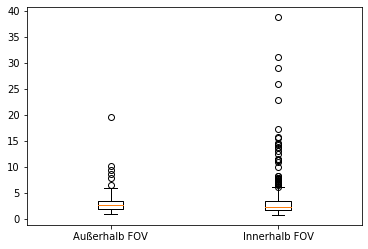

In [230]:
mtl.pyplot.boxplot([outside_fov['click_time'].to_numpy(), inside_fov['click_time'].to_numpy()], labels=['Außerhalb FOV','Innerhalb FOV'])
mtl.pyplot.savefig('FOV.png', dpi = 300)

## Varianztest für beste Interaktionsmethode

In [48]:
shapiro(all_data.click_time)
#-> kleiner als 0.05, damit ist keine normalität gegeben
#ANOVA kann nicht angewendet werden, da eine wiederholte messung stattfindet
#ANOVA für wiederholte messungen kann nicht verwendet werden, da keine normalverteilung besteht
#Friedman test wird verwendet

(0.5135053396224976, 1.2783959094729465e-34)

In [ ]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.friedmanchisquare.html
#Arrays of observations. All of the arrays must have the same number of elements. At least three samples must be given.
#friedmanchisquare(samples*)

In [50]:
def remove_outliers(dataframe):
    std_click_time = dataframe['click_time'].std()
    mean_click_time = dataframe['click_time'].mean()
    return dataframe[dataframe["click_time"] < mean_click_time + 3 * std_click_time]

In [85]:
#load data for all tests and remove outliers
FT_frames = load_df_in_folder(join(path_to_data, 'FT'))
FT_frames = pd.concat(FT_frames)
#FT_frames.reset_index(drop=True)
FT_frames['click_time'] = FT_frames['tsHit'] - FT_frames['tsSpawn']
#FT_frames = remove_outliers(FT_frames)
FR_frames = load_df_in_folder(join(path_to_data, 'FR'))
FR_frames = pd.concat(FR_frames)
#FR_frames.reset_index(drop=True)
FR_frames['click_time'] = FR_frames['tsHit'] - FR_frames['tsSpawn']
#FR_frames = remove_outliers(FR_frames)
ST_frames = load_df_in_folder(join(path_to_data, 'ST'))
ST_frames = pd.concat(ST_frames)
#ST_frames.reset_index(drop=True)
ST_frames['click_time'] = ST_frames['tsHit'] - ST_frames['tsSpawn']
#ST_frames = remove_outliers(ST_frames)
SR_frames = load_df_in_folder(join(path_to_data, 'SR'))
SR_frames = pd.concat(SR_frames)
#SR_frames.reset_index(drop=True)
SR_frames['click_time'] = SR_frames['tsHit'] - SR_frames['tsSpawn']
#SR_frames = remove_outliers(SR_frames)

In [86]:
print(len(FT_frames))
print(len(FR_frames))
print(len(ST_frames))
print(len(SR_frames))

125
125
125
125


In [87]:
friedmanchisquare(FT_frames['click_time'].to_numpy(), FR_frames['click_time'].to_numpy(), ST_frames['click_time'].to_numpy(), SR_frames['click_time'].to_numpy())
#pvalue ist kleiner als 0.05, weshalb keine statistisch signifikanten unterschiede zwischen den tests 

FriedmanchisquareResult(statistic=24.974399999999832, pvalue=1.563197237980571e-05)

In [102]:
FT_frames = remove_outliers(FT_frames)
FR_frames = remove_outliers(FR_frames)
ST_frames = remove_outliers(ST_frames)
SR_frames = remove_outliers(SR_frames)

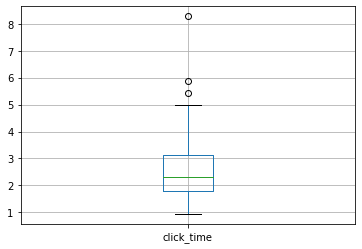

In [93]:
FT_frames.boxplot(['click_time'])

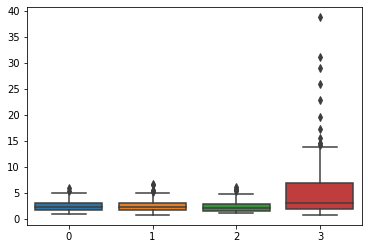

In [113]:
sns.boxplot(data=[FT_frames['click_time'].to_numpy(), FR_frames['click_time'].to_numpy(), ST_frames['click_time'].to_numpy(), SR_frames['click_time'].to_numpy()])

## Beste Fitt's Law Variante finden

In [124]:
#calculate distance to target
distance_list = []
for index, row in all_data.iterrows():
    distance = math.sqrt(row['targetDirX'] * row['targetDirX'] + row['targetDirY'] * row['targetDirY'] + row['targetDirZ'] * row['targetDirZ'])
    distance_list.append(distance)

all_data['distance_to_target'] = distance_list

In [127]:
#ID für Shannons Variante berechnen
#MT = a + b *  ->\log_2((A / W) + 1)<-
sha_ID_list = []
for index, row in all_data.iterrows():
    sha_ID = math.log2((row['distance_to_target'] / row['targetSize']) + 1)
    sha_ID_list.append(sha_ID)

all_data['sha_ID'] = sha_ID_list

In [129]:
#ID für Fitt basisform
#MT = a + b * \log_2(2A / W)
fitt_ID_list = []
for index, row in all_data.iterrows():
    fitt_ID = math.log2((2 * row['distance_to_target'] / row['targetSize']))
    fitt_ID_list.append(fitt_ID)

all_data['fitt_ID'] = fitt_ID_list

In [145]:
#Winkelbasierte Formel aus Angle based paper
#MT = a + b  (u * log_2( (\alpha / \beta) + 1) + (1 - u)log_2((\beta / \omega) + 1 ))
#alpha ist angle_to_target, beta ist fov 43°
#omega ist target_size aber als winkel im sichtfeld -> grad breite im sichtfeld
def get_angle_ID_with_constant(u):
    angle_ID_list = []
    for index, row in all_data.iterrows():
        omega = 2 * math.atan(row['targetSize'] / (2 * row['distance_to_target']))
        beta = 43
        alpha = row['angle_to_target']
        angle_ID = (u * math.log2((alpha / beta) + 1) + (1 - u) * math.log2((beta / omega) + 1))
        angle_ID_list.append(angle_ID)

    all_data['angle_ID'] = angle_ID_list

In [156]:
#Murata MT = a + b * (\log_2(D / W + 1) + c * \sin(\theta))
def get_murata_ID_with_constant(c):
    murata_ID_list = []
    for index, row in all_data.iterrows():
        murata_ID = math.log2(((row ['distance_to_target'] / row['targetSize']) + 1) + c * math.sin(row['angle_to_target']))
        murata_ID_list.append(murata_ID)

    all_data['murata_ID'] = murata_ID_list

In [164]:
best_constant = 0
best_r = 0

In [179]:
for k in range(900,1000):
    get_murata_ID_with_constant(k * 0.001)
    x = all_data['murata_ID'].to_numpy()
    y = all_data['click_time'].to_numpy()

    slope, intercept, r, p, std_err = stats.linregress(x, y)
        
    mymodel = list(map(myfunc, x))
    if (abs(r) > best_r):
        best_constant = k
        best_r = abs(r)
        

In [180]:
print(best_r)
print(best_constant)

0.23374147214941185
999


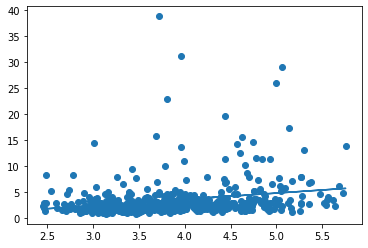

<Figure size 432x288 with 0 Axes>

In [181]:
#linear regression

#x = [5,7,8,7,2,17,2,9,4,11,12,9,6]
#y = [99,86,87,88,111,86,103,87,94,78,77,85,86]
get_murata_ID_with_constant(0.999)
x = all_data['murata_ID'].to_numpy()
y = all_data['click_time'].to_numpy()

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
    return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()
plt.savefig('murata_regression.png', dpi = 300)

In [182]:
print(slope)
print(intercept)
print(r)
print(r*r)

1.2038428799552126
-1.2833178600708135
0.23374147214941185
0.054635075802574276


Results:
Fitt Standard:
Slope: 1.1114394836487844
Intercept: -1.9088578042588034
r: 0.23018191277429012
r*r: 0.05298371296843091

Shannon:
Slope: 1.2010592011375738
Intercept: -1.2733691538537228
r: 0.23138044250887393
r*r: 0.05353690917560232

Winkelbasiert jin et al.: 252
Slope: 1.5223594074242919
Intercept: -7.273730655020447
r: 0.2315717471081723
r*r: 0.053625474058731304

Murata + Iwase: 999
Slope: 1.2038428799552126
Intercept: -1.2833178600708135
r: 0.23374147214941185
r*r: 0.054635075802574276

## Hat Baseline performance auswirkung auf AR Performance?

In [183]:
def load_user_df_in_folder(folder_path):
    files = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    frames = []
    for file in files:
        df = pd.read_csv(join(folder_path, file), sep=';')
        df = df.replace({',': '.'}, regex=True)
        df.columns = df.columns.str.replace(' ', '')
        df = df.apply(pd.to_numeric)
        frames.append(df)
    return frames

In [184]:
#Note: data files in this repository are only provided sorted by test, to avoid duplicate files
user_sorted_files = 'E:\Huc4\Wissenschaftliche_Vertiefung\studienanalyse\Studiendaten\\'
subject_folders = ['ts1', 'ts2', 'ts3', 'ts4', 'ts5']

In [202]:
all_data = load_user_df_in_folder(join(user_sorted_files, 'ts1'))
all_data = pd.concat(all_data)
all_data['click_time'] = all_data['tsHit'] - all_data['tsSpawn']
all_data['gaze_vector'] = list(zip(all_data.gazeX, all_data.gazeY, all_data.gazeZ))
all_data['target_vector'] = list(zip(all_data.targetDirX, all_data.targetDirY, all_data.targetDirZ))
angle_list = []
for index, row in all_data.iterrows():
    angle_list.append(angle_between(row['gaze_vector'], row['target_vector']))

all_data['angle_to_target'] = angle_list
distance_list = []
for index, row in all_data.iterrows():
    distance = math.sqrt(row['targetDirX'] * row['targetDirX'] + row['targetDirY'] * row['targetDirY'] + row['targetDirZ'] * row['targetDirZ'])
    distance_list.append(distance)

all_data['distance_to_target'] = distance_list
get_murata_ID_with_constant(0.999)

IP_sum = 0
for index, row in all_data.iterrows():
    IP_sum = IP_sum + (row['murata_ID'] / row['click_time'])
murata_IP = IP_sum / len(all_data)
print(murata_IP)

2.0635219301032235


Results:

ts1:
murata_IP: 1.3155027789083507
Shannon_baseline_IP: 2.5431410251961455

ts2:
murata_IP: 1.6036340255004178
Shannon_baseline_IP: 2.7293261766419765

ts3:
murata_IP: 1.4926096582851398
Shannon_baseline_IP: 2.784445754766914

ts4:
murata_IP: 1.8543140890346046
Shannon_baseline_IP: 2.9301256876356216

ts5:
murata_IP: 2.0635219301032235
Shannon_baseline_IP: 2.945405838533054

In [ ]:
user_base_sorted_files = '*\studiendatengeordnet\\'


In [224]:
 files = ["*\studiendatengeordnet\\base_pc\\ts5_PC_18_30_59.csv", "*\studiendatengeordnet\\base_tablet\\ts5_Tablet_18_32_45.csv"]
frames = []
for file in files:
    df = pd.read_csv(file, sep=',')
    df.columns = df.columns.str.replace(' ', '')
    df = df.apply(pd.to_numeric)
    frames.append(df)
base_dfs = pd.concat(frames)

base_dfs['click_time'] = (base_dfs['timeStampClick'] - base_dfs['timeStampSpawn']) / 1000

distance_list = []
for index, row in base_dfs.iterrows():
    diffx = row['xPosTarget'] - row['mouseXAtSpawn']
    diffy = row['yPosTarget'] - row['mouseYAtSpawn']
    distance = math.sqrt(diffx * diffx  + diffy * diffy)
    distance_list.append(distance)

base_dfs['distance_to_target'] = distance_list

#ID für Shannons Variante berechnen
#MT = a + b *  ->\log_2((A / W) + 1)<-
sha_ID_list = []
for index, row in base_dfs.iterrows():
    sha_ID = math.log2((row['distance_to_target'] / row['radiusTarget'] * 2) + 1)
    sha_ID_list.append(sha_ID)

base_dfs['sha_ID'] = sha_ID_list

IP_sum = 0
for index, row in base_dfs.iterrows():
    IP_sum = IP_sum + (row['sha_ID'] / row['click_time'])
sha_IP = IP_sum / len(all_data)
print(sha_IP)

2.945405838533054


In [228]:
print(all_data['click_time'].std())
print(all_data['click_time'].mean())

13.234874222703825
4.7463182000000055
